<a href="https://colab.research.google.com/github/Meshal6299/multilingual-movie-reviews-NLP/blob/main/notebooks/02_tokenization_ngram_pos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/Meshal6299/multilingual-movie-reviews-NLP.git

Cloning into 'multilingual-movie-reviews-NLP'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 155 (delta 73), reused 93 (delta 33), pack-reused 0 (from 0)
Receiving objects: 100% (155/155), 5.47 MiB | 10.25 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [3]:
%cd multilingual-movie-reviews-NLP
!ls

# the output should be the following:
# /content/multilingual-movie-reviews-NLP
# data  notebooks  README.md  requirements.txt  run_pipeline.py  src

/content/multilingual-movie-reviews-NLP
data  notebooks  README.md  requirements.txt  run_pipeline.py  src


In [ ]:
import spacy
import pandas as pd
import nltk
from nltk import ngrams
from collections import Counter
import math
import seaborn as sns
import matplotlib.pyplot as plt
from spacy import displacy

In [2]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 6.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 10.1 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [4]:
nlp_en = spacy.load("en_core_web_sm")
nlp_es = spacy.load("es_core_news_sm")

In [6]:
def tokenize_text(doc):
    return [token.text for token in doc if not token.is_punct and not token.is_space]

eng = pd.read_csv("../data/processed/01_cleaned_imdb_en.csv")
spa = pd.read_csv("../data/processed/01_cleaned_imdb_es.csv")

eng["tokens"] = eng["clean_text"].apply(lambda x: tokenize_text(nlp_en(x)))
spa["tokens"] = spa["clean_text"].apply(lambda x: tokenize_text(nlp_es(x)))

In [7]:
print(eng["tokens"].head())
print(spa["tokens"].head())

0    [starts, really, well, nice, intro, and, build...
1    [terrific, movie, if, you, did, not, watch, ye...
2    [i, have, seen, hundreds, of, silent, movies, ...
3    [i, had, been, looking, for, this, film, for, ...
4    [good, engaging, cinematic, firefights, great,...
Name: tokens, dtype: object
0    [comienza, muy, bien, bonita, intro, y, acumul...
1    [película, excelente, si, aún, no, lo, observa...
2    [he, visto, cientos, de, películas, silenciosa...
3    [había, estado, buscando, esta, película, dura...
4    [bueno, atractiva, firefights, cinematicales, ...
Name: tokens, dtype: object


In [8]:
# --- Compute tokenization statistics ---
avg_tokens_en = eng["tokens"].apply(len).mean()
avg_tokens_es = spa["tokens"].apply(len).mean()

total_tokens_en = sum(eng["tokens"].apply(len))
total_tokens_es = sum(spa["tokens"].apply(len))

vocab_size_en = len(set([word for tokens in eng["tokens"] for word in tokens]))
vocab_size_es = len(set([word for tokens in spa["tokens"] for word in tokens]))

In [14]:
token_stats = pd.DataFrame({
    "Language": ["English", "Spanish"],
    "Avg. Tokens per Review": [round(avg_tokens_en, 2), round(avg_tokens_es, 2)],
    "Total Tokens": [total_tokens_en, total_tokens_es],
    "Vocabulary Size": [vocab_size_en, vocab_size_es]
})

print("🧩 Tokenization Summary:\n")
display(token_stats)

🧩 Tokenization Summary:



,Language,Avg. Tokens per Review,Total Tokens,Vocabulary Size
0,English,233.62,2336232,51471
1,Spanish,238.07,2380704,80983


In [15]:
# Flatten tokens
tokens_en = [token for tokens in eng["tokens"] for token in tokens]
tokens_es = [token for tokens in spa["tokens"] for token in tokens]

# Split into train/test (95% / 5%)
split_en = int(0.95 * len(tokens_en))
split_es = int(0.95 * len(tokens_es))

#English training and testing
train_en = tokens_en[:split_en]
test_en = tokens_en[split_en:]

#Spanish training and testing
train_es = tokens_es[:split_es]
test_es = tokens_es[split_es:]

#bigram models for both languages
bigrams_en = list(ngrams(train_en, 2))
bigrams_es = list(ngrams(train_es, 2))

#frequency for both unigrams and bigrams
model_en_bi = Counter(bigrams_en)
model_es_bi = Counter(bigrams_es)
model_en_uni = Counter(train_en) #only counts from the training
model_es_uni = Counter(train_es)

vocab_size_en = len(model_en_uni)
vocab_size_es = len(model_es_uni)

In [16]:
def calculate_perplexity(bigram_model, unigram_model, test_tokens, train_vocab_size, n=2):

    N = len(test_tokens)

    ngrams_list = list(ngrams(test_tokens, n))

    log_prob = 0

    for ng in ngrams_list:
        context = ng[:-1] # from (word1 ,word2) to just (word1)
        word_minus_1 = context[0] # now we store word1

        count_bigram = bigram_model[ng] #how many times do we have (word1, word2)
        count_unigram = unigram_model[word_minus_1] #how many times do we have (word1)

        prob = (count_bigram + 1) / (count_unigram + train_vocab_size) # P = (count(word1, word2) + 1) / (count(word1) + v)

        log_prob += -math.log(prob) #keeps adding the prob

    return math.exp(log_prob / N)

pp_en = calculate_perplexity(model_en_bi, model_en_uni, test_en, vocab_size_en)
pp_es = calculate_perplexity(model_es_bi, model_es_uni, test_es, vocab_size_es)

print(f"English Perplexity: {pp_en:.2f}")
print(f"Spanish Perplexity: {pp_es:.2f}")

#the preplexity for both language might be high because we used a bigram and a small dataset, but we might improve it later if needed.

English Perplexity: 2946.62
Spanish Perplexity: 4454.98


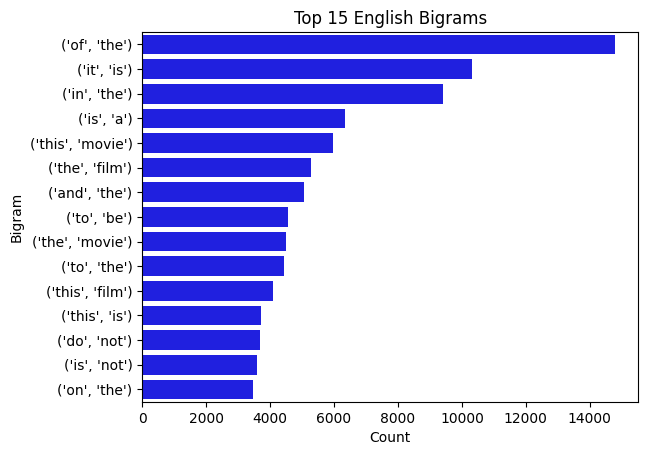

In [17]:
# Top 15 English bigrams
df_en = pd.DataFrame(model_en_bi.most_common(15), columns=["Bigram", "Count"])
df_en["Bigram"] = df_en["Bigram"].astype(str)

sns.barplot(data=df_en, y="Bigram", x="Count", color="blue")
plt.title("Top 15 English Bigrams")
plt.show()

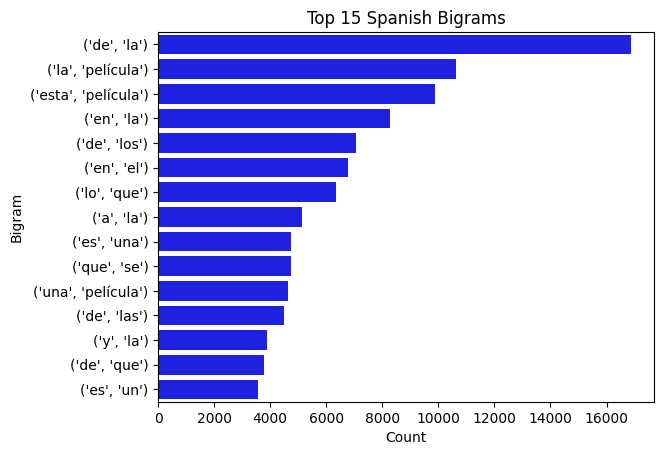

In [18]:
# Top 15 Spanish bigrams
df_es = pd.DataFrame(model_es_bi.most_common(15), columns=["Bigram", "Count"])
df_es["Bigram"] = df_es["Bigram"].astype(str)

sns.barplot(data=df_es, y="Bigram", x="Count", color="blue")
plt.title("Top 15 Spanish Bigrams")
plt.show()

In [20]:
def pos_tag_text(doc):
    return [(token.text, token.pos_) for token in doc if not token.is_punct and not token.is_space]

# Apply POS tagging
eng["pos_tags"] = eng["clean_text"].apply(lambda x: pos_tag_text(nlp_en(x)))
spa["pos_tags"] = spa["clean_text"].apply(lambda x: pos_tag_text(nlp_es(x)))

print("✅ POS tagging complete for both languages.")

✅ POS tagging complete for both languages.


In [ ]:
def get_pos_distribution(docs):
    pos_counts = Counter([pos for doc in docs for _, pos in doc])
    total = sum(pos_counts.values())
    return {pos: round(count / total * 100, 2) for pos, count in pos_counts.items()}

pos_en = get_pos_distribution(eng["pos_tags"])
pos_es = get_pos_distribution(spa["pos_tags"])

# Convert to DataFrame for visualization
pos_df = pd.DataFrame([pos_en, pos_es], index=["English", "Spanish"]).fillna(0)

print("these are the POS distributions(%): ")
pos_df


these are the POS distributions(%): 


,VERB,ADV,ADJ,NOUN,CCONJ,ADP,DET,AUX,SCONJ,PRON,PART,PROPN,NUM,INTJ,PUNCT,X,SYM
English,11.94,6.31,8.93,20.58,3.85,10.41,10.84,6.98,2.47,10.14,3.22,3.40,0.61,0.24,0.0,0.06,0.0
Spanish,10.78,6.14,8.84,20.35,3.74,13.76,13.96,5.17,3.06,6.47,0.03,7.33,0.32,0.04,0.0,0.00,0.0


In [35]:
doc_en = nlp_en(eng["clean_text"][0])
doc_spa = nlp_es(spa["clean_text"][0])

# Force displaCy not to use Jupyter
html = displacy.render(doc_en, style="dep", jupyter=False)
html += displacy.render(doc_spa, style="dep", jupyter=False)

# Save to file
with open("../src/dependency.html", "w", encoding="utf-8") as f:
    f.write(html)

print("✅ Dependency tree saved as dependency.html")

✅ Dependency tree saved as dependency.html
